<a href="https://colab.research.google.com/github/miladqolamee/NeuroMatch_2022_group_project/blob/main/Coding_Exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This notebook is created for exploratory data analysis on Allen 2P dataset by **Pierogi All Stras** 

---
# A brief summary of Allen 2P Experiment Design


- Single and multiple-plane 2 photon calcium imaging was used.
- Exitatory and inhibitory populaiton of nuerons were imaged in different cre-lines.
- Each population was imaged over multiple days and under different experimental conditions (with familiar, novel stimuli and under active and passive veiwing conditions)
- This dataset can be used to evaluate the influence of experience, expectation and task engagemen on neural coding and dynamics.
- Overal, we have 82 mouse, 3021 behavioral sessions and 551 imaging sessions. In total 34619 cells were recorded.
- Mice performed a go/no go visual change detection task. Visual stimui were presented continuously for 1 hour. The start of trial was not indicated and mouse was free to run.

For more information see:
[Link](https://allensdk.readthedocs.io/en/latest/visual_behavior_optical_physiology.html).

# Experimental setup 

<img src="https://github.com/miladqolamee/NeuroMatch_2022_group_project/blob/main/Allen%20viewing%20condition.png?raw=1" alt="Experimental setup" class="bg-primary" width="75%">

---
# A brief summary of Allen 2P Dataset
To access data in the dataset we can instal `allensdk` package. By using `AllenBehaviorOphysProjectCache` object and its methods in this package we can access desired data. 

In the dataset we have 3 tables and 2 datasets streams. We should use informatin inside the table to extract our desired subset of information. These 3 tables are:

1) Behavior Sessions Table: Contains metadata for behavioral sessions (both trianing session and also sessions whcih imaging was perfomed). This table can be accessed by `get_behavior_session_talbe()` method.

2) Ophys Sessions Table: Contains metadata and experimental conditions for all sessions. This talbe can accessed by `get_ophys_session_table()` method.

3) Ophys Experiments Table: Contains metadata and experimental conditions fo all imaging experiment (aka imaging plane). This table can be accessed by `get_experiment_session_table()` method.

For more information see:
[Link](https://github.com/miladqolamee/NeuroMatch_2022_group_project/blob/main/VBP_WhitePaper_SDK_Documentation.pdf).

# Allen 2P dataset terminology

<img src="https://allensdk.readthedocs.io/en/latest/_static/visual_behavior_2p/data_structure.png" alt="dataset terminology" class="bg-primary" width="100%">

# It is recommended to run codes line by line whenever staff get complicated

## You can run each line or see content of variables by highlighting it and then press `control` + `shift`+ `inter`

---
# First instal `mindscope_utilities` package which includes `allensdk` package and some other useful functions for our data analyis

In [2]:
!pip install pip --upgrade --quiet
!pip install mindscope_utilities --quiet

     |████████████████████████████████| 2.1 MB 5.4 MB/s 
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.1/64.1 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.3/130.3 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 MB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 668.3/668.3 kB 42.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.3/54.3 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.3/130.3 kB 13.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 72.9 MB/s eta 0:00:00
     

In [3]:
#  @title Improt relevant packages
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.manifold import TSNE
from pathlib import Path

import mindscope_utilities
import mindscope_utilities.visual_behavior_ophys as ophys

from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorOphysProjectCache

from IPython.core.pylabtools import figsize
plt.rcParams['figure.figsize'] = [15, 8]

pd.set_option('display.max_columns', 500)

## First we need a file path because we need to pass it to cache object to indicate where the file should be downloaded

## By calling `VisualBehaviorOphysProjectCache`, Tables will be downloaded

In [4]:
# Update this to a valid directory in your filesystem
data_storage_directory = Path("/local1/visual_behavior_ophys_cache_dir")

cache = VisualBehaviorOphysProjectCache.from_s3_cache(cache_dir=data_storage_directory)

ophys_session_table.csv: 100%|██████████| 227k/227k [00:00<00:00, 1.56MMB/s] 
behavior_session_table.csv: 100%|██████████| 1.21M/1.21M [00:00<00:00, 6.95MMB/s]
ophys_experiment_table.csv: 100%|██████████| 610k/610k [00:00<00:00, 3.92MMB/s] 
ophys_cells_table.csv: 100%|██████████| 4.29M/4.29M [00:00<00:00, 12.5MMB/s]


## Experiment Sessions Table

In [5]:
experiment_table = cache.get_ophys_experiment_table()   # Getting Experiment Session Table
experiment_table.sample(5)                              # Show 5 random observation
print(len(experiment_table))                            # How many rows?
print(len(experiment_table.ophys_session_id.unique()))  # How many unique imaging session

1941
704


## Selecting experiments for VIP and SST nuerons

In [6]:
experiment_variables = experiment_table.columns      # All variables in behavior table

experiment_table.cre_line.unique()    # How many unique cre-line we have

Vip_experiment_table = experiment_table[(experiment_table.cre_line.values == 'Vip-IRES-Cre') & 
                                    (experiment_table.ophys_session_id.isnull() == False)]
Sst_experiment_table = experiment_table[(experiment_table.cre_line.values == 'Sst-IRES-Cre') & 
                                    (experiment_table.ophys_session_id.isnull() == False)]


# getting information just for one mouse for simplification and sort its table by date of aquisition
Vip_mouse_id = Vip_experiment_table.mouse_id.unique()[0]
Sst_mouse_id = Sst_experiment_table.mouse_id.unique()[0]

this_mouse_Vip_experiment_table = experiment_table[(experiment_table.cre_line.values == 'Vip-IRES-Cre') & 
                                    (experiment_table.ophys_session_id.isnull() == False)
                                    & (experiment_table.mouse_id.values == Vip_mouse_id)].sort_values(
                                        by = 'date_of_acquisition')
this_mouse_Sst_experiment_table = experiment_table[(experiment_table.cre_line.values == 'Sst-IRES-Cre') & 
                                    (experiment_table.ophys_session_id.isnull() == False)
                                    & (experiment_table.mouse_id.values == Sst_mouse_id)].sort_values(
                                        by = 'date_of_acquisition')



For this specific Vip mouse we have six imaging session sorted by date of aquisition. In `session_type` column it can be seen what type of image was presented and what kind of task (active or passive ) was performed. 
In the following cells we want to compare the neural response around stimulus omittion during active and passive task.

In [78]:


# getting passive and active experiment ids for this mouse (just one active and one passive session where "image_B" was presented)
this_mouse_Vip_passive_experiment_id = this_mouse_Vip_experiment_table[this_mouse_Vip_experiment_table.session_type.str.contains("passive")].index[0]
this_mouse_Vip_active_experiment_id = this_mouse_Vip_experiment_table[~this_mouse_Vip_experiment_table.session_type.str.contains("passive")].index[2]


# loading experiment dataset 
this_mouse_Vip_passive_experiment = cache.get_behavior_ophys_experiment(this_mouse_Vip_passive_experiment_id)
this_mouse_Vip_active_experiment = cache.get_behavior_ophys_experiment (this_mouse_Vip_active_experiment_id)

Int64Index([796108483, 798404219], dtype='int64', name='ophys_experiment_id')

Look at the performance of these two sessions (one active and the other passive)  


In [8]:
this_mouse_Vip_passive_experiment.get_performance_metrics()   # perfomance metrics of this passice session
this_mouse_Vip_active_experiment.get_performance_metrics()    # perfomance metrics of this active session


{'auto_reward_count': 0,
 'catch_trial_count': 29,
 'correct_reject_trial_count': 23,
 'earned_reward_count': 95,
 'engaged_trial_count': 359,
 'false_alarm_trial_count': 6,
 'go_trial_count': 214,
 'hit_trial_count': 95,
 'max_dprime': 1.7569793388565886,
 'max_dprime_engaged': 1.7569793388565886,
 'maximum_reward_rate': 3.8884890786023485,
 'mean_dprime': 0.9371263733924384,
 'mean_dprime_engaged': 1.3222974859601826,
 'mean_false_alarm_rate': 0.24103280121798643,
 'mean_false_alarm_rate_engaged': 0.26769341769341765,
 'mean_false_alarm_rate_uncorrected': 0.21697015832818303,
 'mean_hit_rate': 0.5755366893467753,
 'mean_hit_rate_engaged': 0.7495907381688044,
 'mean_hit_rate_uncorrected': 0.5717488105588966,
 'miss_trial_count': 119,
 'total_reward_count': 95,
 'total_reward_volume': 0.6650000000000001,
 'trial_count': 692}

Looking at identified cells in these experiment

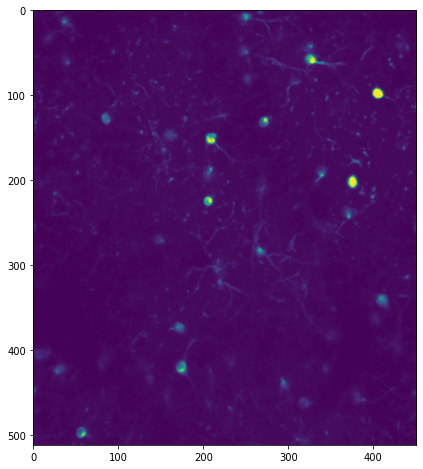

In [40]:

# First take a look at cell_specimen_id table which contains information about identified cells in this scecimen
this_mouse_Vip_passive_experiment.cell_specimen_table.head()
this_mouse_Vip_active_experiment.cell_specimen_table.head()

# Then lets visualize the specimen 

plt.imshow(this_mouse_Vip_passive_experiment.max_projection)
plt.imshow(this_mouse_Vip_active_experiment.max_projection)

Loading all neural data into a pandas 'tidy' format

In [42]:
this_mouse_Vip_passive_neural_data = ophys.build_tidy_cell_df(this_mouse_Vip_passive_experiment)
this_mouse_Vip_active_neural_data = ophys.build_tidy_cell_df(this_mouse_Vip_active_experiment)
# How many cells we have?
print(f'We have: {len(this_mouse_Vip_passive_neural_data.cell_roi_id.unique())} unique cells in this experiment')
print(f'We have: {len(this_mouse_Vip_active_neural_data.cell_roi_id.unique())} unique cells in this experiment')



We have: 44 unique cells in this experiment
We have: 33 unique cells in this experiment


In the next cell we want to choose one of the cells and extract timestams for that cell during the the entire experiment

In [92]:
Neuron = 25   # you can change this to see result for different neurons (select a number between 0 to 33)

# Selecting a cell from passive session
cell_id_passive = this_mouse_Vip_passive_neural_data.cell_roi_id.unique()[Neuron]
this_mouse_Vip_passive_neural_data_single_cell = this_mouse_Vip_passive_neural_data.query('cell_roi_id == @cell_id_passive')
this_mouse_Vip_passive_neural_data_single_cell.head()

# Selecting a cell from active session
cell_id_active = this_mouse_Vip_active_neural_data.cell_roi_id.unique()[Neuron]
this_mouse_Vip_active_neural_data_single_cell = this_mouse_Vip_active_neural_data.query('cell_roi_id == @cell_id_active')
this_mouse_Vip_active_neural_data_single_cell.head()

,timestamps,dff,events,filtered_events,cell_roi_id,cell_specimen_id
0,3.17722,0.991442,0.0,0.0,1080896225,1086491118
1,3.20953,0.935235,0.0,0.0,1080896225,1086491118
2,3.24183,0.809872,0.0,0.0,1080896225,1086491118
3,3.27414,1.263882,0.0,0.0,1080896225,1086491118
4,3.30644,0.453779,0.0,0.0,1080896225,1086491118


Finally our first plot!

We want to plot dff (fluorescence signal) against time

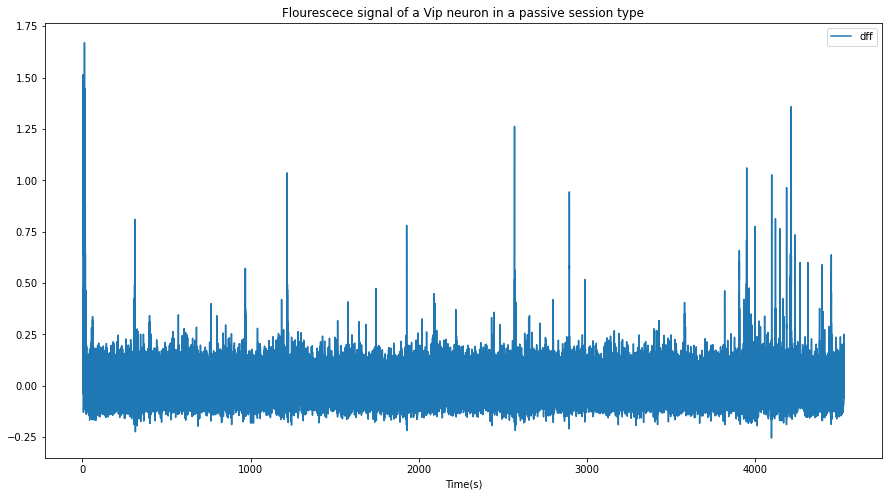

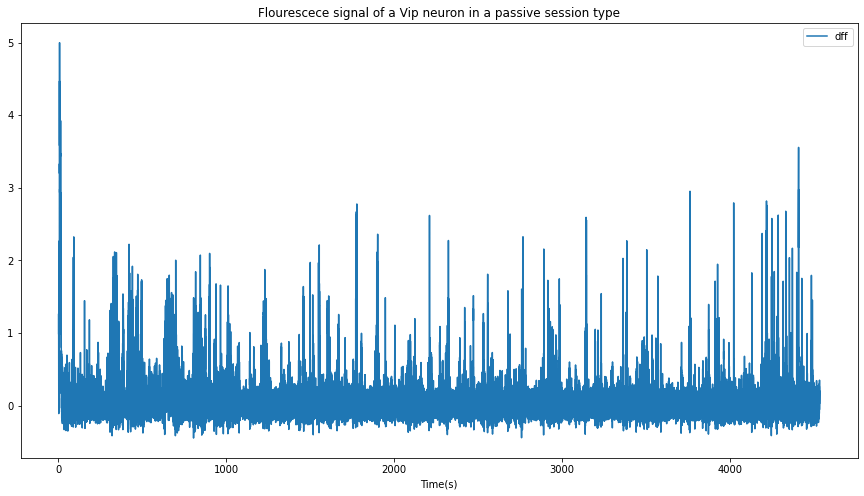

In [93]:
# ploting for the passive cell
this_mouse_Vip_passive_neural_data_single_cell.plot(
    x = 'timestamps',
    y = 'dff'
)
plt.xlabel('Time(s)')
plt.title('Flourescece signal of a Vip neuron in a passive session type')
# plt.xlim(0,100)       # you can zoon in or out any section fo x axis by 
                        # changing the limits of lower and upper boundries (first uncomment)

                        # ploting for the passive cell
this_mouse_Vip_active_neural_data_single_cell.plot(
    x = 'timestamps',
    y = 'dff'
)
plt.xlabel('Time(s)')
plt.title('Flourescece signal of a Vip neuron in a passive session type')
# plt.xlim(0,100)       # you can zoon in or out any section fo x axis by 
                        # changing the limits of lower and upper boundries (first uncomment)
plt.show()



Looking at stimulus table which is sahred acorss all experiments in that session and describes details of stimulus presentation in that session

In [94]:
# First for passive cell
this_mouse_Vip_passive_stimulus_talbe = this_mouse_Vip_passive_experiment.stimulus_presentations
this_mouse_Vip_passive_stimulus_talbe.head()

# Then for active cell

this_mouse_Vip_active_stimulus_talbe = this_mouse_Vip_active_experiment.stimulus_presentations
this_mouse_Vip_active_stimulus_talbe.head()

,start_time,stop_time,duration,image_name,image_index,is_change,omitted,start_frame,end_frame,image_set
stimulus_presentations_id,,,,,,,,,,
0,306.90981,307.16002,0.25021,im000,0,False,False,17985,18000.0,Natural_Images_Lum_Matched_set_ophys_6_2017.07.14
1,307.66042,307.91060,0.25018,im000,0,False,False,18030,18045.0,Natural_Images_Lum_Matched_set_ophys_6_2017.07.14
2,308.41101,308.66123,0.25022,im000,0,False,False,18075,18090.0,Natural_Images_Lum_Matched_set_ophys_6_2017.07.14
3,309.16175,309.41187,0.25012,im000,0,False,False,18120,18135.0,Natural_Images_Lum_Matched_set_ophys_6_2017.07.14
4,309.91222,310.16246,0.25024,im000,0,False,False,18165,18180.0,Natural_Images_Lum_Matched_set_ophys_6_2017.07.14


# Create an event triggered response dataframe relative to omissions
If we want to see how a given cell responds when regularly flashed stimuli are omitted, we can calculate the response around each of the stimulus omissions. The `mindscope_utilities` package has a convenience function to do this. We give the function:
* a dataframe of interest (containing activity from one cell)
* the t and y values of interest
* the event times
* how much time before and after each event we are interested in
* the desired sampling rate of the output - this is the rate onto which the response will be interpolated

The function will return a new dataframe with the response for the given cell, aligned to each of the events.

In [95]:
# First for passive cell
event_trig_response_passive = mindscope_utilities.event_triggered_response(
    data = this_mouse_Vip_passive_neural_data_single_cell,
    t = 'timestamps',
    y = 'dff',
    event_times= this_mouse_Vip_passive_stimulus_talbe.query('omitted == True')['start_time'],
    t_before = 3,
    t_after = 3,
    output_sampling_rate= 50
)
event_trig_response_passive.head(10)

# Then for active cell

event_trig_response_active = mindscope_utilities.event_triggered_response(
    data = this_mouse_Vip_active_neural_data_single_cell,
    t = 'timestamps',
    y = 'dff',
    event_times= this_mouse_Vip_active_stimulus_talbe.query('omitted == True')['start_time'],
    t_before = 3,
    t_after = 3,
    output_sampling_rate= 50
)
event_trig_response_active.head(10)

,time,dff,event_number,stimulus_presentations_id,event_time
0,-3.00,-0.098936,0,104,384.95678
1,-2.98,-0.103415,0,104,384.95678
2,-2.96,-0.117325,0,104,384.95678
3,-2.94,-0.133013,0,104,384.95678
4,-2.92,-0.149189,0,104,384.95678
5,-2.90,-0.162834,0,104,384.95678
6,-2.88,-0.122379,0,104,384.95678
7,-2.86,-0.021891,0,104,384.95678
8,-2.84,-0.056903,0,104,384.95678
9,-2.82,-0.094266,0,104,384.95678


The function `mindscope_utilities.event_triggered_response` extracts neural activity around our desired event. 

The output format of the event_triggered_response function is designed to plug directly into Seaborn's lineplot plotting function. We can then view the mean response to omitted stimuli with 95% confidence intervals very easily:

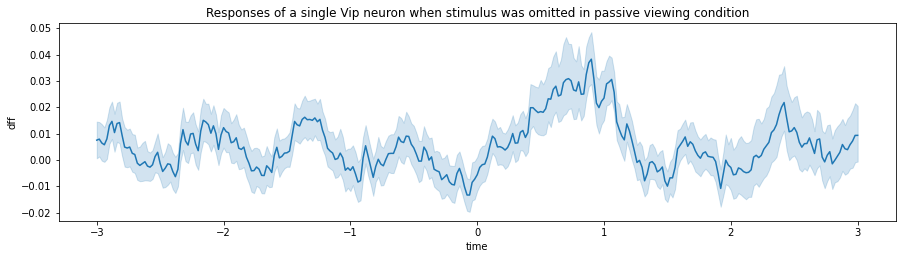

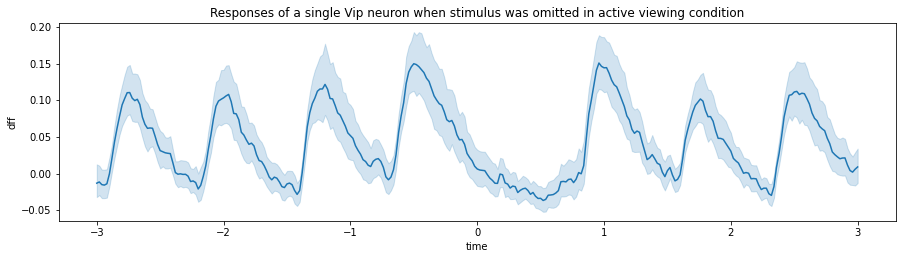

In [96]:
# First for passive cell
plt.subplot(2,1,1)
sns.lineplot(
    data = event_trig_response_passive,
    x = 'time',
    y = 'dff',
    n_boot = 500
) 
plt.title('Responses of a single Vip neuron when stimulus was omitted in passive viewing condition')
plt.show()

# Then for active cell
plt.subplot(2,1,2)
sns.lineplot(
    data = event_trig_response_active,
    x = 'time',
    y = 'dff',
    n_boot = 500
) 
plt.title('Responses of a single Vip neuron when stimulus was omitted in active viewing condition')
plt.show()

In [ ]:
#Just a code that might help later on
#M='M'
#behavior_table.query('sex == @ M')
#This way we can specifically ask for the data containing these parameters. the mouse only being male (which is better since female mices' results aren't as reliable)